This notebook is adapted from [a lesson from the 2017 KIPAC/StatisticalMethods course](https://github.com/KIPAC/StatisticalMethods/blob/2017winter/chunks/generative_models.ipynb), (c) 2017 Adam Mantz and Phil Marshall. The GPLv2 license applies.

***Note for the DSFP***

To get this notebook (and my other lectures), you will need to not just
```
git pull
```
the DSFP repository, but also
```
git submodule update --init
```

(In the grand tradition of opening the crate with the crowbar you will find inside...)

# Generative Models

Goals:
* Introduce generative models in the context of mocking data and inference
* Introduce probabilistic graphical models as a tool for model visualization
* Practice building some simple models

A **generative model** formalizes our understanding of how a data set comes to exist, including
* physical processes happening out there in the Universe
* instrumental effects and the measurement process
* any computations done prior to calling the result a "data set"

In other words, it's what we need in order to generate a mock data set.

To actually generate mock data, we need to specify the **sampling distribution**, $P(\mathrm{data}|\mathrm{model})$. This PDF is the mathemetical expression of our generative model.
* It shows up directly in Bayes Theorem, and ideally (as a function of model parameters) as the likelihood function in maximum-likelihood fitting.

What are generative models useful for?

* Performing inference: constructing the *sampling distribution* or *likelihood function*

* Testing inference: does our analysis, run on mock data, recover the input model?

* Checking inferences: do mock data generated from a fitted model resemble the real data?

A **probabilistic graphical model** (PGM) is a very useful way of visualizing a generative model.
* They sketch out the procedure for how one would generate mock data in practice.
* They illustrate the interdependence of model parameters, and the dependence of data on parameters.
* They also (therefore) represent a conditional factorization of the sampling distribution.

**Many, many** mistakes can be avoided by sketching out a PGM at the outset of a statistical analysis.

Technically, a PGM is a type of *directed acyclic graph*, where **nodes** and **edges** represent parts of the model.

Let's look at a very simple example...

<table><tr width=90%>
<td><img src="../graphics/tour_cluster_image.png" height=300></td>
<td><img src="../graphics/tour_cluster_image_zoom.png" height=300></td>
</tr></table>

Our measurement is the number of counts in each pixel. Here is a generative model:

* There's an object emitting light, whose properties are parametrized by $\theta$.

* From $\theta$, we can determine the average flux falling on a given pixel $k$, $F_k$.

* Given the exposure time of our observation, $T$, and some conversion factors, $F_k$ determines the average number of counts expected, $\mu_k$.

* The number of counts measured, $N_k$, is a Poisson draw, given the average $\mu_k$.

Notice that the model was described in terms of conditional relationships.
* $\theta \Rightarrow F_k$
* $F_k,T \Rightarrow \mu_k$
* $N_k \sim \mathrm{Poisson}(\mu_k)$

The PGM will do the same, visually.

<img src="../graphics/pgms_pixelcounts.png">

Ingredients of a PGM:
* **Nodes** represent parameters
* **Edges** represent conditional relationships
* **Plates** represent repeated model components whose contents are conditionally independent

Types of nodes:
* **Circles** represent a PDF. This parameter is a *stochastic* function of the parameters feeding into it.
* **Points** represent a delta-function PDF. This parameter is a *deterministic* function of the parameters feeding into it.
* **Double circles** (or shading) indicate measured data. They are stochastic in the context of generating mock data, but fixed in the context of parameter inference.

Q: What is this PGM telling us?

<img src="../graphics/pgms_pixelcounts.png">

Q: How are these PGMs different, and what does the difference mean?

<table><tr><td>
<img src="../graphics/pgms_pixelcounts.png">
</td><td>
<img src="../graphics/pgms_pixelcounts2.png">
</td></tr></table>

By mapping the conditional dependences of a model, PGMs illustrate how to factorize the sampling distribution:

$P(\theta) \prod_k P(N_k|\mu_k)P(\mu_k|F_k,T)P(F_k|\theta)$

<img src="../graphics/pgms_pixelcounts.png">

In this case, some PDFs are delta functions, so we can simplify:

$P(\theta)P(T) \prod_k P(N_k|\mu_k)P(\mu_k|F_k,T)P(F_k|\theta)$

$= \underbrace{P(\theta)} ~ \underbrace{\prod_k P\left[N_k|\mu_k(\theta,T)\right]}$

$= \mathrm{prior}(\theta) ~\times~ (\mathrm{sampling~distribution~of~}\vec{N})$

**Exercise**

<table><tr>
<td><img src="../graphics/pgms_a-c-d.png"></td>
<td><img src="../graphics/pgms_c-y-d.png"></td>
</tr></table>

* On your own, write down the probability expressions illustrated by these two graphs. 
* Then, discuss their meaning with your neighbor, and prepare to report back to the class.

**Take-home messages**

* Both simulation of mock data and model inference from data require a model for how the Universe (or our computer) generates data.
* PGMs are a helpful way of visualizing the conditional dependences of a model (how the probability expressions factorize).

Note: the `daft` Python package is useful for making pretty PGMs.

## Practice

** (Solutions) **

For scribbled PGM solutions, see [this image](generative_models_soln.jpg). These are not guaranteed to be perfect, and are offered with minimal explanation, apart from the following:
* For the transit problem, I introduced a "$W(t)$" nuisance parameter for weather, which is assumed to affect the recieved flux of any source equally.
* For the galaxy cluster problem, I introduced a "group membership" variable, which would simply say whether a given cluster is well centered (0) or mis-centered (1). You may see this kind of thing more in the hierachical modeling lectures.

Just to emphasize it, there's a fair bit of amiguity in the descriptions below, so it's entire possible for legitimate solutions to look different from mine!

### "Standard" linear regression

You're given a list of $x_k,y_k,\sigma_k$ triplets, where $\sigma_k$ is some estimate of the "error" on $y_k$. You'd like to fit a linear model, $y(x)=a+bx$. In the absence of any better information, assume that $\vec{x}$ and $\vec{\sigma}$ are (somehow) known precisely, and that the "error" on $y_k$ is Gaussian (mean of $a+bx_k$ and standard deviation $\sigma_k$).

1. Draw the PGM and write down the corresponsing probability expressions for this problem.
2. Simulate a few data sets, given some values (your choice) for the input parameters. The code below is a (crummy) starting point.
3. What (unspecified) assumptions, if any, did you have to make? Which assumptions do you think are unlikely to hold in practice? Choose one (or more) of these assumptions and work out how to generalize the PGM/generative model to avoid making it.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'
%matplotlib inline

In [2]:
# choose some linear model parameters, somehow
a = np.pi
b = 1.0/np.sqrt(2.0)

# choose some x and sigma values... somehow
n = 10 # Number of data points. Feel free to change.
x = st.uniform.rvs(-5., 5., size=n)
sigma = np.sqrt(st.chi2.rvs(2, size=n))

# work out the values for any intermediate nodes
ybar = a + b*x

# generate the "observed" y values
y = st.norm.rvs(ybar, sigma, size=n)

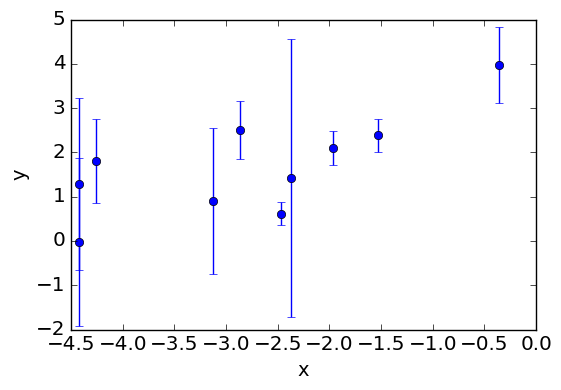

In [6]:
# plot x, y and sigma in the usual way
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.errorbar(x, y, yerr=sigma, fmt='none');
plt.plot(x, y, 'bo');
plt.xlabel('x', fontsize=14);
plt.ylabel('y', fontsize=14);

### Exoplanet transit photometry

You've taken several images of a particular field, in order to record the transit of an exoplanet in front of a star (resulting in a temporary decrease in its brightness). Some kind of model, parametrized by $\theta$, describes the time series of the resulting flux. Before we get to measure a number of counts, however, each image is affected by time-specific variables, e.g. related to changing weather. To account for these, you've also measured 10 other stars in the same field in every exposure. The assumption is that the average intrinsic flux of these stars should be constant in time, so that they can be used to correct for photometric variations, putting the multiple measurements of the target star on the same scale.

Draw the PGM and write down the corresponsing probability expressions for this problem.

Thanks to Anja von der Linden for inspiring (and then correcting) the above problem.

### Galaxy cluster center offsets

You've measured the centers of a sample of galaxy clusters in two ways: by choosing a brightest cluster galaxy (BCG) and by finding the centroid of each cluster's X-ray emission. The difference between the two should say something about the fidelity of the BCG selection method, among other things. The BCG positions are determined essentially perfectly, but the X-ray centroids come with a Gaussian statistical uncertainty of typically $\sim30$ kpc (standard deviation) in both the $x$ and $y$ directions.

The underlying model is assumed to be that the BCG and true X-ray centroid coincide perfectly in a fraction $f$ of clusters. In the remaining clusters, the true X-ray centroid and BCG are displaced according to a 2D Gaussian whose width in either direction is $\sigma=100$ kpc.

1. Draw the PGM and write down the corresponsing probability expressions for this problem.
2. Simulate some data sets and visualize them, e.g. as a histogram of the offset distances.

Thanks to the bloody Universe for inspiring the above problem.